## Multiunit recordings from several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [17]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [18]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/spks")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/faces")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [19]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [20]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # ms (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 


mouse: Krebs

mouse: Waksman

mouse: Robbins
area:  FrMoCtx
population: 0
    time: 220719
    cells: 16
... Dynamical Analysis
    population firing: 1.03±1.09 sp/frame
    cells firing rate: 0.06±0.26 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.1894241024512153
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 6068
    number of events per sec: 1.0990404225183745
    events duration: 0.090±0.038
    events size: 5.000±1.985
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.37537057619222297
    cluster size threshold: 2
    Total number of clusters: 36
    # clusters (after removing those below reproducibility threshold): 36
    event color assignment
    unique color assignments
    clustered similarity map

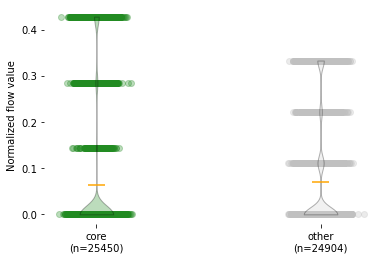


    Cut edges sourcing from cores: DescribeResult(nobs=7, minmax=(0.0, 432.14285714285717), mean=77.51020408163265, variance=26147.84936831876, skewness=1.801296364192453, kurtosis=1.549855997733685)
    Cut edges targeting cores: DescribeResult(nobs=7, minmax=(0.0, 976.0), mean=143.30612244897958, variance=134926.03692905736, skewness=2.038031750547709, kurtosis=2.159527862497015)
    Cut edges sourcing from others: DescribeResult(nobs=9, minmax=(0.0, 436.0), mean=119.07407407407406, variance=31485.71604938271, skewness=0.8506880076312148, kurtosis=-1.0539288232320982)
    Cut edges targeting others: DescribeResult(nobs=9, minmax=(0.0, 338.44444444444446), mean=79.27160493827161, variance=16180.991083676272, skewness=1.1161411316541525, kurtosis=-0.25840827206950756)
    Core targets vs sources Welch t test:  0.434 p= 0.676
    Kolmogorov-Smirnov Effect Size: 0.143
    Core targets vs Other targets Welch t test:  0.441 p= 0.672
    Kolmogorov-Smirnov Effect Size: 0.190


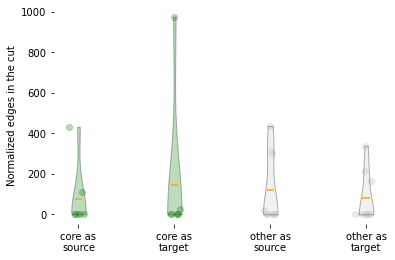

... PageRank centrality
    cores: DescribeResult(nobs=7, minmax=(0.054545454545454564, 0.1913373513857566), mean=0.08167864636012274, variance=0.002730409890209805, skewness=1.5600044237579322, kurtosis=0.8540990814878935)
    others: DescribeResult(nobs=9, minmax=(0.0, 0.1875545148083829), mean=0.04758327505323788, variance=0.006599973306667382, skewness=1.196388320298651, kurtosis=-0.4223430911488615)
    Kruskal-Wallis test:  4.643 p= 0.031
    Kolmogorov-Smirnov Effect Size: 0.778


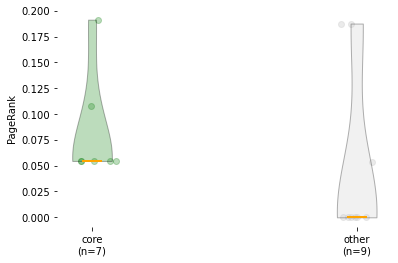

population: 1
    time: 220433
    cells: 70
... Dynamical Analysis
    population firing: 2.80±1.98 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.0471063827529585
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 12048
    number of events per sec: 2.1797103127363253
    events duration: 0.080±0.038
    events size: 18.000±5.258
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19402184281119636
    cluster size threshold: 2
    Total number of clusters: 155
    # clusters (after removing those below reproducibility threshold): 155
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unsp

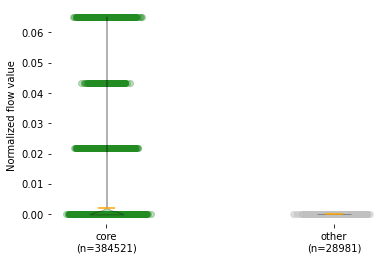


    Cut edges sourcing from cores: DescribeResult(nobs=46, minmax=(0.0, 73.84782608695652), mean=9.058601134215502, variance=444.54383258906154, skewness=2.3626855113254135, kurtosis=4.160900849605055)
    Cut edges targeting cores: DescribeResult(nobs=46, minmax=(0.0, 204.1304347826087), mean=9.0586011342155, variance=1166.2710747650747, skewness=4.623913421786254, kurtosis=22.18781422665344)
    Cut edges sourcing from others: DescribeResult(nobs=24, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=24, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  -0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.130
    Core targets vs Other targets Welch t test:  1.799 p= 0.079
    Kolmogorov-Smirnov Effect Size: 0.239


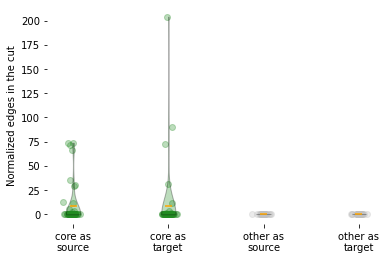

... PageRank centrality
    cores: DescribeResult(nobs=46, minmax=(0.00702576112412178, 0.12130251374655139), mean=0.021271296752408655, variance=0.0006483678625792933, skewness=2.0642689173539326, kurtosis=4.1554430024931275)
    others: DescribeResult(nobs=24, minmax=(0.0, 0.02152034938920184), mean=0.0008966812245500766, variance=1.9296893243054995e-05, skewness=4.587317109255644, kurtosis=19.04347826086957)
    Kruskal-Wallis test:  46.731 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.958


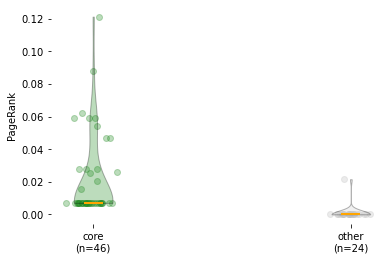

area:  SomMoCtx
population: 0
    time: 220727
    cells: 10
... Dynamical Analysis
    population firing: 0.53±0.79 sp/frame
    cells firing rate: 0.05±0.25 sp/s
... generating surrogates to establish population event threshold
... entering reshuffling
    event size threshold (mean): 1.0477701165690312
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 4569
    number of events per sec: 0.8279828858166478
    events duration: 0.090±0.039
    events size: 3.000±1.046
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
    entering creation of surrogate signatures
    cluster reproducibility threshold: 0.43354545395998695
    cluster size threshold: 2
    Total number of clusters: 14
    # clusters (after removing those below reproducibility threshold): 14
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster 

/tmp/ipykernel_67095/1935952453.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)
... Flow Analysis
    Flow cores: DescribeResult(nobs=14066, minmax=(0.0, 0.4), mean=0.01828522678799943, variance=0.006980237445440921, skewness=4.350113338413607, kurtosis=16.923486057043977)
    Flow others: DescribeResult(nobs=8522, minmax=(0.0, 0.4), mean=0.13156536024407417, variance=0.03532084474760522, skewness=0.7283094121342664, kurtosis=-1.4695654001966398)
    Welch t test:  -52.584 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.283


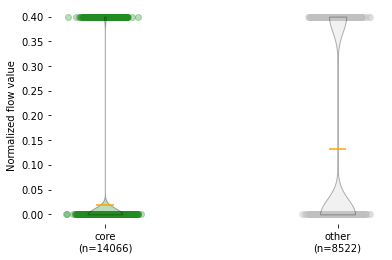


    Cut edges sourcing from cores: DescribeResult(nobs=5, minmax=(0.0, 216.0), mean=43.2, variance=9331.2, skewness=1.5, kurtosis=0.25)
    Cut edges targeting cores: DescribeResult(nobs=5, minmax=(0.0, 257.2), mean=51.44, variance=13230.367999999999, skewness=1.4999999999999998, kurtosis=0.24999999999999956)
    Cut edges sourcing from others: DescribeResult(nobs=5, minmax=(0.0, 344.6), mean=94.64000000000001, variance=22625.868000000006, skewness=1.076989471089126, kurtosis=-0.46928873253114034)
    Cut edges targeting others: DescribeResult(nobs=5, minmax=(0.0, 432.0), mean=86.4, variance=37324.8, skewness=1.5, kurtosis=0.24999999999999956)
    Core targets vs sources Welch t test:  0.123 p= 0.905
    Kolmogorov-Smirnov Effect Size: 0.200
    Core targets vs Other targets Welch t test:  -0.348 p= 0.739
    Kolmogorov-Smirnov Effect Size: 0.200


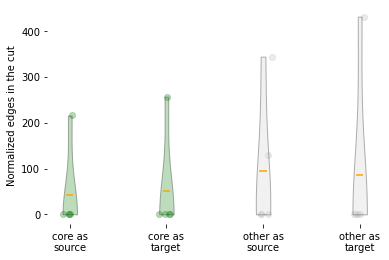

... PageRank centrality
    cores: DescribeResult(nobs=5, minmax=(0.09375, 0.25219298245614036), mean=0.12543859649122807, variance=0.005020835737919361, skewness=1.5, kurtosis=0.24999999999999956)
    others: DescribeResult(nobs=5, minmax=(0.0, 0.18640350877192982), mean=0.07456140350877193, variance=0.010423880424746075, skewness=0.408248290463863, kurtosis=-1.8333333333333335)
    Kruskal-Wallis test:  0.972 p= 0.324
    Kolmogorov-Smirnov Effect Size: 0.600


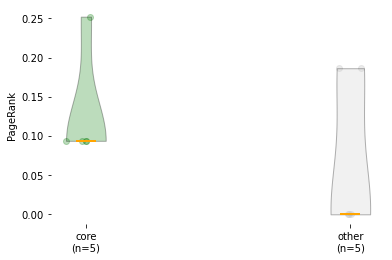

area:  RSP
population: 0
    time: 220348
    cells: 10
... Dynamical Analysis
    population firing: 0.75±0.87 sp/frame
    cells firing rate: 0.07±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 1.118779691932134
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 15583
    number of events per sec: 2.816618828309703
    events duration: 0.080±0.035
    events size: 3.000±1.358
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.41838730485283165
    cluster size threshold: 2
    Total number of clusters: 16
    # clusters (after removing those below reproducibility threshold): 16
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firin

/tmp/ipykernel_67095/1935952453.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)
... Flow Analysis
    Flow cores: DescribeResult(nobs=66945, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Flow others: DescribeResult(nobs=14889, minmax=(0.0, 0.25), mean=0.0003694002283565048, variance=9.221979438098062e-05, skewness=25.957160997693403, kurtosis=671.7742070601757)
    Welch t test:  -4.694 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.001


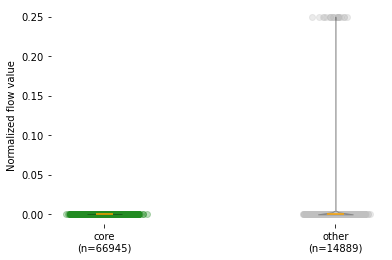


    Cut edges sourcing from cores: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting cores: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges sourcing from others: DescribeResult(nobs=4, minmax=(0.0, 2.75), mean=0.6875, variance=1.890625, skewness=1.1547005383792515, kurtosis=-0.6666666666666665)
    Cut edges targeting others: DescribeResult(nobs=4, minmax=(0.0, 2.75), mean=0.6875, variance=1.890625, skewness=1.1547005383792515, kurtosis=-0.6666666666666665)
    Core targets vs sources Welch t test:  nan p= nan
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  -1.000 p= 0.391
    Kolmogorov-Smirnov Effect Size: 0.250


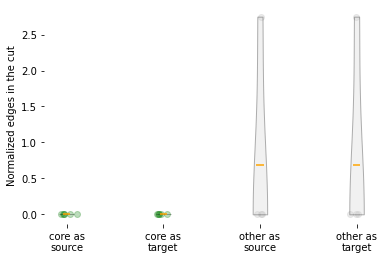

... PageRank centrality
    cores: DescribeResult(nobs=6, minmax=(0.16666666666666666, 0.16666666666666666), mean=0.16666666666666666, variance=0.0, skewness=0.0, kurtosis=-3.0)
    others: DescribeResult(nobs=4, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  9.000 p= 0.003
    Kolmogorov-Smirnov Effect Size: 1.000


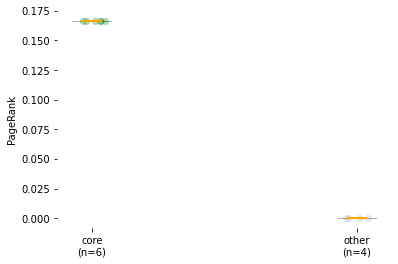

In [22]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\nmouse:",mousename)
    
    # # to reduce computations, use comments here
    # if mousename not in ["Krebs", "Waksman"]:
    # if mousename not in ["Waksman","Robbins"]:
    # if mousename not in ["Robbins"]:
    #     continue
        
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # # to reduce computations, use comments here
            # if area not in ['FrCtx', 'FrMoCtx']:
            # if area not in ['V1']:
            #     continue
                                                
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                if mousename=='Waksman' and area=='FrMoCtx' and ipop==1:
                    continue # no events

                # rounding to ms
                # spiketrains = [np.round(sp, 3) for sp in spiketrains] # ms
                spiketrains = [np.round(sp, 2) for sp in spiketrains] # 10ms
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)
                print("    time:", len(time))
                print("    cells:", len(spiketrains))

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # --------------------------------------------------------------------------
                print("... Dynamical Analysis")
                core_reproducibility_perc = 99 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                
                # --------------------------------------------------------------------------
                # dimensional reduction, trajectories, and manifold analysis
                print("... Manifold Analysis")
                %run "attractor_analysis.ipynb"

                # --------------------------------------------------------------------------
                # Functional structure analysis
                %run "functional_analysis.ipynb"
                
    gc.collect()
    print()    